In [1]:
import torch
import os
import numpy as np
from hmc_u1 import HMC_U1
from hmc_u1_ft import HMC_U1_FT
from cnn_model import FieldTransformation
from utils import hmc_summary


In [2]:
# Parameters
lattice_size = 8
volume = lattice_size ** 2
beta = 5
n_thermalization_steps = 200
n_steps = 50
step_size = 0.07
n_iterations = 1024

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# Set default type
torch.set_default_dtype(torch.float32)

### No Field Transformation

>>> No Field Transformation HMC Simulation: 


Thermalizing:   0%|          | 0/200 [00:00<?, ?it/s]

Running HMC: 100%|██████████| 1024/1024 [00:11<00:00, 86.49it/s]


>>> Simulation completed


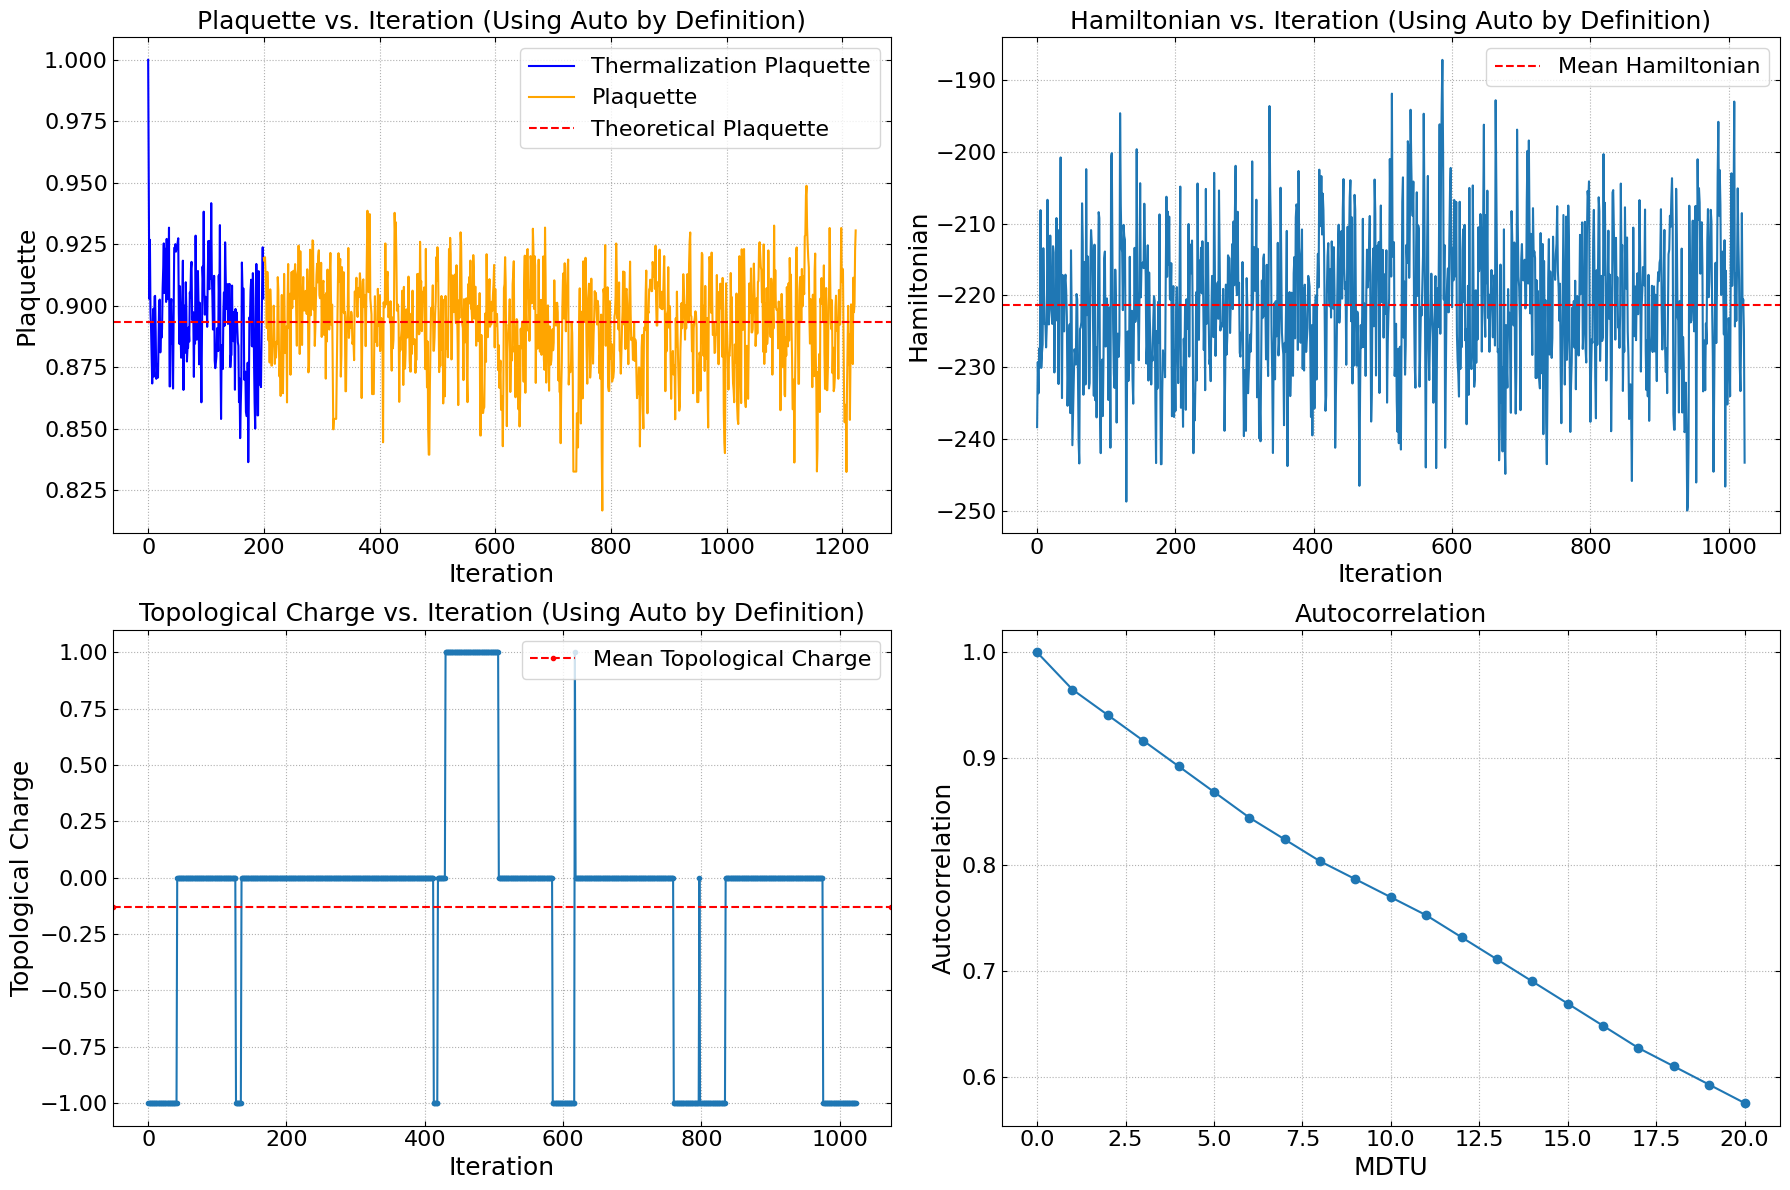

>>> Theoretical plaquette:  0.8933831370440852
>>> Mean plaq:  0.8922972020809539
>>> Std of mean plaq:  0.0006154645789126265
Thermalization acceptance rate: 0.9500
Acceptance rate: 0.9414


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
config_ls, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_fig = hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)
hmc_fig.savefig(f'plots/hmc_L{lattice_size}_beta{beta}.pdf', transparent=True)

# Save configurations for training
np.save(f'dump/theta_ori_L{lattice_size}_beta{beta}.npy', torch.stack(config_ls).detach().cpu().numpy())


### Neural Network Field Transformation

>>> Neural Network Field Transformation HMC Simulation: 


/home/jinchen/miniconda3/envs/lat/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Loaded data shape: torch.Size([1024, 2, 8, 8])
Training data shape: torch.Size([819, 2, 8, 8])
Testing data shape: torch.Size([205, 2, 8, 8])
>>> Training the model


Training epochs:   6%|▋         | 1/16 [01:19<19:59, 79.94s/it]

Epoch 1/16 - Train Loss: 12.371598 - Test Loss: 8.628161


Training epochs:  12%|█▎        | 2/16 [02:40<18:43, 80.27s/it]

Epoch 2/16 - Train Loss: 7.594890 - Test Loss: 7.749182


Training epochs:  19%|█▉        | 3/16 [04:00<17:21, 80.15s/it]

Epoch 3/16 - Train Loss: 6.916591 - Test Loss: 7.186031


Training epochs:  25%|██▌       | 4/16 [05:20<16:03, 80.28s/it]

Epoch 4/16 - Train Loss: 6.444944 - Test Loss: 6.921875


Training epochs:  31%|███▏      | 5/16 [06:40<14:40, 80.03s/it]

Epoch 5/16 - Train Loss: 6.148006 - Test Loss: 6.779126


Training epochs:  38%|███▊      | 6/16 [08:00<13:19, 79.99s/it]

Epoch 6/16 - Train Loss: 5.947675 - Test Loss: 6.652480


Training epochs:  44%|████▍     | 7/16 [09:20<12:01, 80.17s/it]

Epoch 7/16 - Train Loss: 5.792692 - Test Loss: 6.550125


Training epochs:  50%|█████     | 8/16 [10:41<10:43, 80.40s/it]

Epoch 8/16 - Train Loss: 5.684116 - Test Loss: 6.463212


Training epochs:  56%|█████▋    | 9/16 [12:02<09:23, 80.52s/it]

Epoch 9/16 - Train Loss: 5.536460 - Test Loss: 6.386301


Training epochs:  62%|██████▎   | 10/16 [13:23<08:03, 80.62s/it]

Epoch 10/16 - Train Loss: 5.457116 - Test Loss: 6.323506


Training epochs:  69%|██████▉   | 11/16 [14:44<06:43, 80.66s/it]

Epoch 11/16 - Train Loss: 5.322840 - Test Loss: 6.257345


Training epochs:  75%|███████▌  | 12/16 [16:05<05:23, 80.82s/it]

Epoch 12/16 - Train Loss: 5.335768 - Test Loss: 6.221807


Training epochs:  81%|████████▏ | 13/16 [17:26<04:02, 80.83s/it]

Epoch 13/16 - Train Loss: 5.224945 - Test Loss: 6.163995


Training epochs:  88%|████████▊ | 14/16 [18:47<02:41, 80.99s/it]

Epoch 14/16 - Train Loss: 5.191883 - Test Loss: 6.117606


Training epochs:  94%|█████████▍| 15/16 [20:08<01:20, 80.97s/it]

Epoch 15/16 - Train Loss: 5.087535 - Test Loss: 6.099581


Training epochs: 100%|██████████| 16/16 [21:29<00:00, 80.58s/it]

Epoch 16/16 - Train Loss: 5.037666 - Test Loss: 6.045210


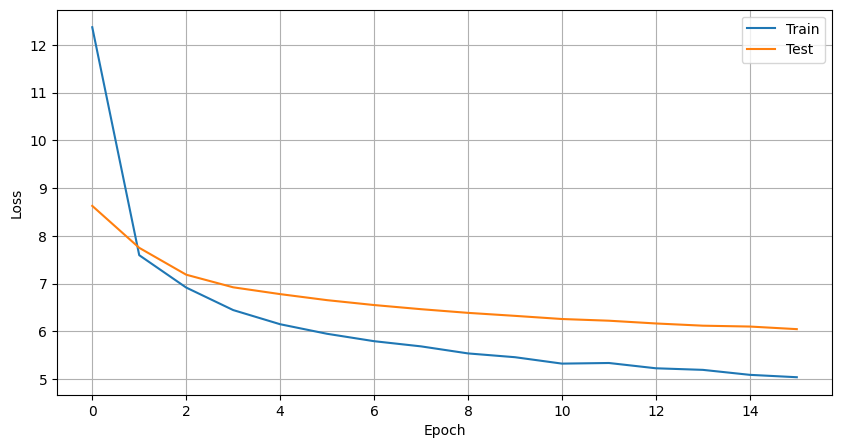

Loaded best models from epoch 15 with loss 6.045210
>>> Loading the trained models
Loaded best models from epoch 15 with loss 6.045210
>>> Models loaded successfully


Running HMC: 100%|██████████| 1024/1024 [37:03<00:00,  2.17s/it]


>>> Simulation completed


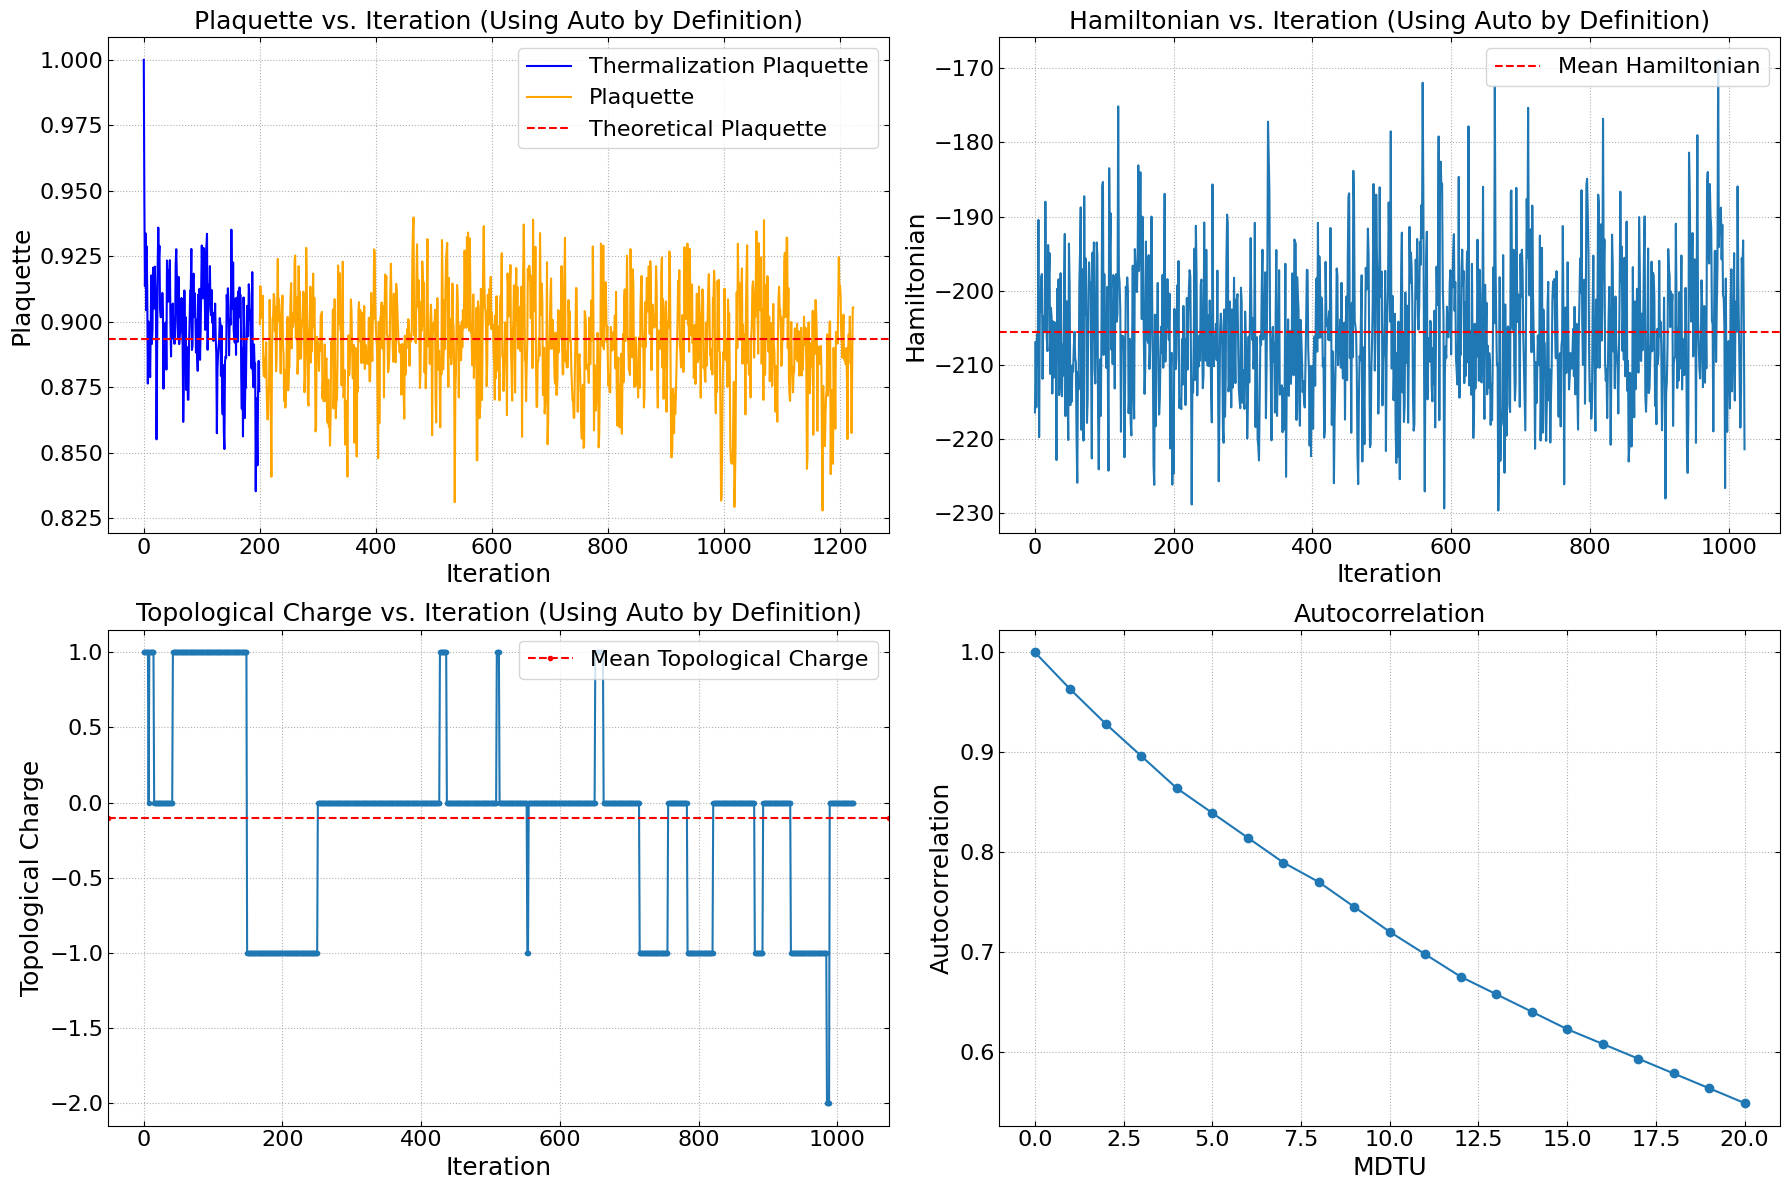

>>> Theoretical plaquette:  0.8933831370440852
>>> Mean plaq:  0.8922432029503398
>>> Std of mean plaq:  0.0005861011573855963
Thermalization acceptance rate: 0.9800
Acceptance rate: 0.9648


In [4]:
print(">>> Neural Network Field Transformation HMC Simulation: ")

# initialize the field transformation
nn_ft = FieldTransformation(lattice_size, device=device, n_subsets=8, beta=beta, if_check_jac=False) #todo
# nn_ft.model.load_state_dict(torch.load('models/cnn_save.pt'), weights_only=False)

# load the data
data = np.load(f'dump/theta_ori_L{lattice_size}_beta{beta}.npy')
tensor_data = torch.from_numpy(data).float().to(device)
print(f"Loaded data shape: {tensor_data.shape}")

# split the data into training and testing
train_size = int(0.8 * len(tensor_data))
train_data = tensor_data[:train_size]
test_data = tensor_data[train_size:]
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# train the model
if not os.path.exists(f'models/best_model_L{lattice_size}_beta{beta}.pt'): 
    print(">>> Training the model")
    nn_ft.train(train_data, test_data, beta, n_epochs=16, batch_size=32)

# Load the trained models
print(">>> Loading the trained models")
nn_ft._load_best_model()
print(">>> Models loaded successfully")


field_transformation = nn_ft.field_transformation
compute_jac_logdet = nn_ft.compute_jac_logdet

# Initialize HMC with field transformation
n_steps = 50
step_size = 0.07
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=field_transformation, compute_jac_logdet=compute_jac_logdet, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_fig = hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)
hmc_fig.savefig(f'plots/hmc_ft_L{lattice_size}_beta{beta}.pdf', transparent=True)
